# Main notebook for battery state estimation

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import math
import os
import ntpath
import sys
import logging
import time
import sys

from importlib import reload
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import tikzplotlib
from matplotlib.font_manager import FontProperties

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.layers import LSTM, Embedding, RepeatVector, TimeDistributed, Masking
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback


IS_COLAB = False

if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/battery-state-estimation/battery-state-estimation/"
else:
    data_path = "../../../"

sys.path.append(data_path)
from data_processing.unibo_powertools_data import UniboPowertoolsData, CycleCols
from data_processing.model_data_handler import ModelDataHandler

### Config logging

In [2]:
reload(logging)
logging.basicConfig(format='%(asctime)s [%(levelname)s]: %(message)s', level=logging.DEBUG, datefmt='%Y/%m/%d %H:%M:%S')

# Load Data

### Initial the data object

Load the cycle and capacity data to memory based on the specified chunk size

In [3]:
dataset = UniboPowertoolsData(
    test_types=[],
    chunk_size=1000000,
    lines=[37, 40],
    charge_line=37,
    discharge_line=40,
    base_path=data_path
)

2021/01/10 15:58:21 [DEBUG]: Start loading data with lines: [37, 40], types: [] and chunksize: 1000000...
2021/01/10 15:58:38 [DEBUG]: Finish loading data.
2021/01/10 15:58:38 [INFO]: Loaded raw dataset A data with cycle row count: 8485716 and capacity row count: 21604
2021/01/10 15:58:38 [DEBUG]: Start cleaning cycle raw data...
2021/01/10 15:58:43 [DEBUG]: Finish cleaning cycle raw data.
2021/01/10 15:58:43 [INFO]: Removed 11 rows of abnormal cycle raw data.
2021/01/10 15:58:43 [DEBUG]: Start cleaning capacity raw data...
2021/01/10 15:58:43 [DEBUG]: Finish cleaning capacity raw data.
2021/01/10 15:58:43 [INFO]: Removed 1 rows of abnormal capacity raw data.
2021/01/10 15:58:43 [DEBUG]: Start assigning charging raw data...
2021/01/10 15:58:44 [DEBUG]: Finish assigning charging raw data.
2021/01/10 15:58:44 [INFO]: [Charging] cycle raw count: 6671942, capacity raw count: 10804
2021/01/10 15:58:44 [DEBUG]: Start assigning discharging raw data...
2021/01/10 15:58:44 [DEBUG]: Finish assig

### Determine the training and testing name

Prepare the training and testing data for model data handler to load the model input and output data.

In [4]:
train_data_test_names = [
    '000-DM-3.0-4019-S',  
    '001-DM-3.0-4019-S',  
    '002-DM-3.0-4019-S', 

    '006-EE-2.85-0820-S', 
    '007-EE-2.85-0820-S',
    '042-EE-2.85-0820-S',

    '009-DM-3.0-4019-H',  
    '010-DM-3.0-4019-H',

    '013-DM-3.0-4019-P',  
    '014-DM-3.0-4019-P',
    '015-DM-3.0-4019-P',  
    '016-DM-3.0-4019-P', 

    '018-DP-2.00-1320-S', 
    '019-DP-2.00-1320-S', 
    '036-DP-2.00-1720-S',
    '037-DP-2.00-1720-S', 
    '038-DP-2.00-2420-S',

    '043-EE-2.85-0820-H',
    
    '040-DM-4.00-2320-S', 
    #'045-BE-2.75-2019-S'
]

test_data_test_names = [
    '003-DM-3.0-4019-S', 
    '008-EE-2.85-0820-S', 
    '011-DM-3.0-4019-H', 
    '017-DM-3.0-4019-P', 
    '039-DP-2.00-2420-S',
    '044-EE-2.85-0820-H',
    
    '041-DM-4.00-2320-S',
]

dataset.prepare_data(train_data_test_names, test_data_test_names)

2021/01/10 15:58:44 [DEBUG]: Start preparing data for training: ['000-DM-3.0-4019-S', '001-DM-3.0-4019-S', '002-DM-3.0-4019-S', '006-EE-2.85-0820-S', '007-EE-2.85-0820-S', '042-EE-2.85-0820-S', '009-DM-3.0-4019-H', '010-DM-3.0-4019-H', '013-DM-3.0-4019-P', '014-DM-3.0-4019-P', '015-DM-3.0-4019-P', '016-DM-3.0-4019-P', '018-DP-2.00-1320-S', '019-DP-2.00-1320-S', '036-DP-2.00-1720-S', '037-DP-2.00-1720-S', '038-DP-2.00-2420-S', '043-EE-2.85-0820-H', '040-DM-4.00-2320-S'] and testing: ['003-DM-3.0-4019-S', '008-EE-2.85-0820-S', '011-DM-3.0-4019-H', '017-DM-3.0-4019-P', '039-DP-2.00-2420-S', '044-EE-2.85-0820-H', '041-DM-4.00-2320-S']...
2021/01/10 15:58:59 [DEBUG]: Finish getting training and testing charge data.
2021/01/10 15:59:11 [DEBUG]: Finish getting training and testing discharge data.
2021/01/10 15:59:11 [DEBUG]: Finish cleaning training and testing charge data.
2021/01/10 15:59:11 [DEBUG]: Finish cleaning training and testing discharge data.
2021/01/10 15:59:13 [DEBUG]: Finish ad

### Initial the model data handler

Model data handler will be used to get the model input and output data for further training purpose.

In [5]:
mdh = ModelDataHandler(dataset, [
    CycleCols.VOLTAGE,
    CycleCols.CURRENT,
    CycleCols.TEMPERATURE
])

# Data loading

In [6]:
train_x, train_y, test_x, test_y = mdh.get_discharge_whole_cycle(soh = False, output_capacity = False)

2021/01/10 15:59:25 [INFO]: Train x: (7738, 287, 3), train y: (7738, 287, 2) | Test x: (2425, 287, 3), test y: (2425, 287, 2)


In [7]:
train_y = mdh.keep_only_capacity(train_y, is_multiple_output = True)
test_y = mdh.keep_only_capacity(test_y, is_multiple_output = True)

2021/01/10 15:59:25 [INFO]: New y: (7738, 287)
2021/01/10 15:59:25 [INFO]: New y: (2425, 287)


In [8]:
# Model definition

#opt = tf.keras.optimizers.Adam(lr=0.00003)

#model = Sequential()
#model.add(LSTM(256, activation='selu',
#                return_sequences=True,
#                input_shape=(train_x.shape[1], train_x.shape[2])))
#model.add(LSTM(256, activation='selu', return_sequences=True))
#model.add(LSTM(128, activation='selu', return_sequences=True))
#model.add(Dense(64, activation='selu'))
#model.add(Dense(1, activation='linear'))
#model.summary()

#model.compile(optimizer=opt, loss='huber', metrics=['mse', 'mae', 'mape', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [9]:
experiment_name = '2021-01-09-19-26-25_lstm_soc_percentage_all_types'

history = pd.read_csv(data_path + 'results/trained_model/%s_history.csv' % experiment_name)
model = keras.models.load_model(data_path + 'results/trained_model/%s.h5' % experiment_name)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 287, 256)          266240    
_________________________________________________________________
lstm_1 (LSTM)                (None, 287, 256)          525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 287, 128)          197120    
_________________________________________________________________
dense (Dense)                (None, 287, 64)           8256      
_________________________________________________________________
dense_1 (Dense)              (None, 287, 1)            65        
Total params: 996,993
Trainable params: 996,993
Non-trainable params: 0
_________________________________________________________________


In [10]:
print(history)

     Unnamed: 0      loss       mse       mae          mape      rmse  \
0             0  0.015187  0.031145  0.066541  9.877259e+06  0.176480   
1             1  0.004033  0.008066  0.029723  2.318631e+06  0.089810   
2             2  0.002943  0.005886  0.026607  2.406742e+06  0.076722   
3             3  0.002318  0.004636  0.024298  2.475839e+06  0.068089   
4             4  0.001937  0.003875  0.023728  2.869112e+06  0.062247   
..          ...       ...       ...       ...           ...       ...   
175         175  0.000025  0.000050  0.005034  1.235371e+06  0.007040   
176         176  0.000012  0.000024  0.003146  5.914005e+05  0.004854   
177         177  0.000014  0.000028  0.003554  7.429594e+05  0.005269   
178         178  0.000014  0.000028  0.003621  7.937099e+05  0.005258   
179         179  0.000013  0.000025  0.003343  6.902987e+05  0.005003   

     val_loss   val_mse   val_mae     val_mape  val_rmse  
0    0.005750  0.011499  0.045200  2479688.500  0.107235  
1    

In [11]:
results = model.evaluate(test_x, test_y)
print(results)

76/76 [==============================] - 9s 122ms/step - loss: 8.9151e-05 - mean_squared_error: 1.7830e-04 - mean_absolute_error: 0.0069 - mean_absolute_percentage_error: 1171802.8750 - rmse: 0.0134
[8.915134094422683e-05, 0.00017830268188845366, 0.006907269358634949, 1171802.875, 0.013353003188967705]


# Data Visualization

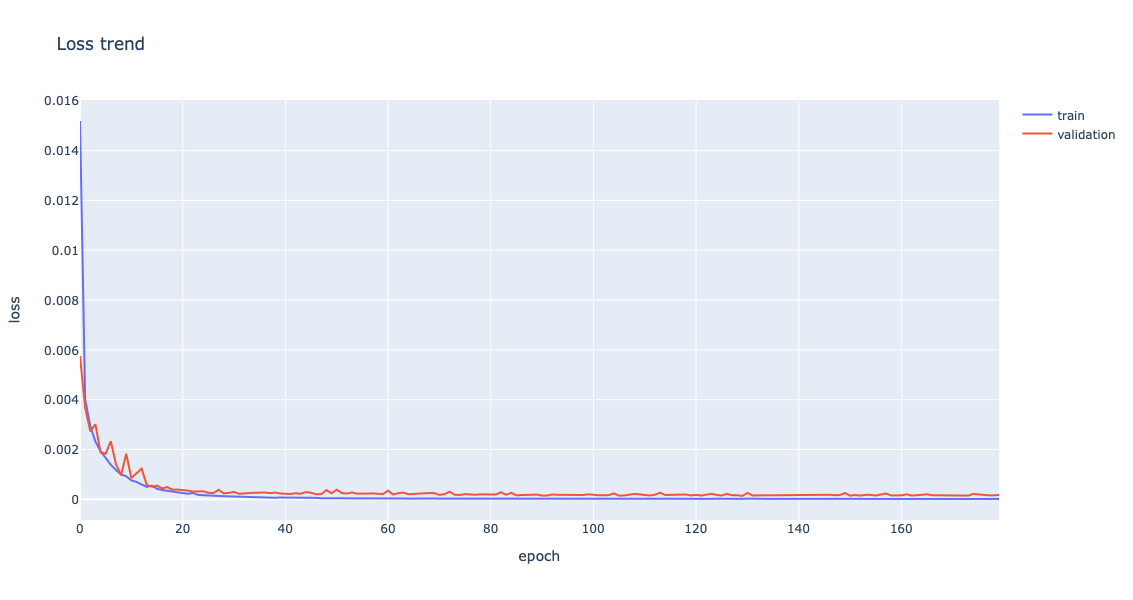

In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history['loss'],
                    mode='lines', name='train'))
fig.add_trace(go.Scatter(y=history['val_loss'],
                    mode='lines', name='validation'))
fig.update_layout(title='Loss trend',
                  xaxis_title='epoch',
                  yaxis_title='loss',
                  width=1400,
                  height=600)
fig.show()

In [13]:
train_predictions = model.predict(train_x)

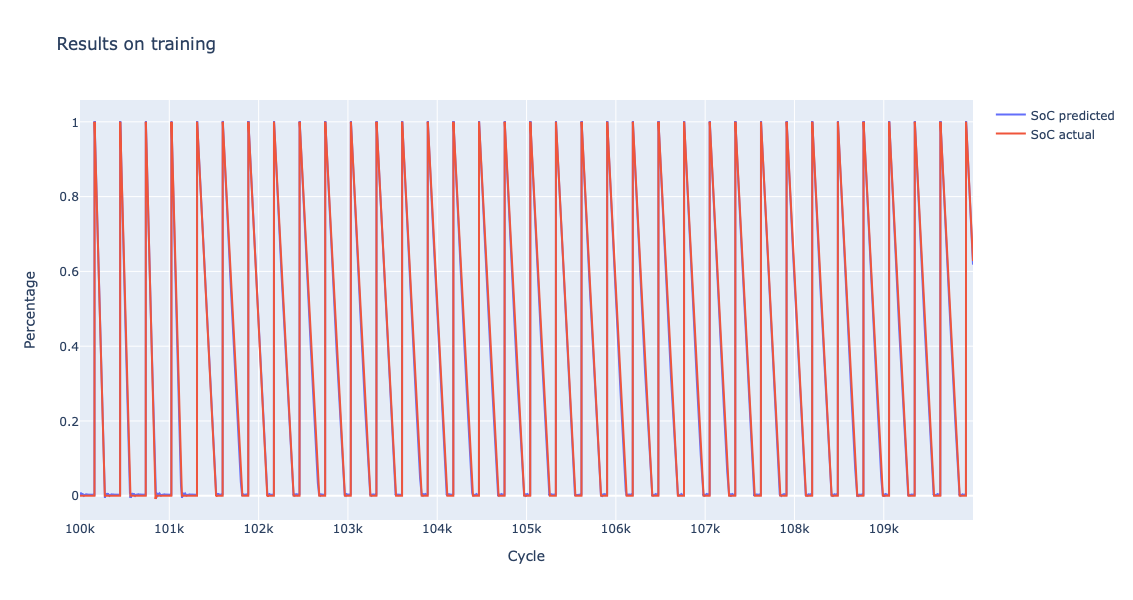

In [14]:
cycle_num = 10
steps_num = 10000
step_index = np.arange(cycle_num*steps_num, (cycle_num+1)*steps_num)

fig = go.Figure()
fig.add_trace(go.Scatter(x=step_index, y=train_predictions.flatten()[cycle_num*steps_num:(cycle_num+1)*steps_num],
                    mode='lines', name='SoC predicted'))
fig.add_trace(go.Scatter(x=step_index, y=train_y.flatten()[cycle_num*steps_num:(cycle_num+1)*steps_num],
                    mode='lines', name='SoC actual'))
fig.update_layout(title='Results on training',
                  xaxis_title='Cycle',
                  yaxis_title='Percentage',
                  width=1400,
                  height=600)
fig.show()

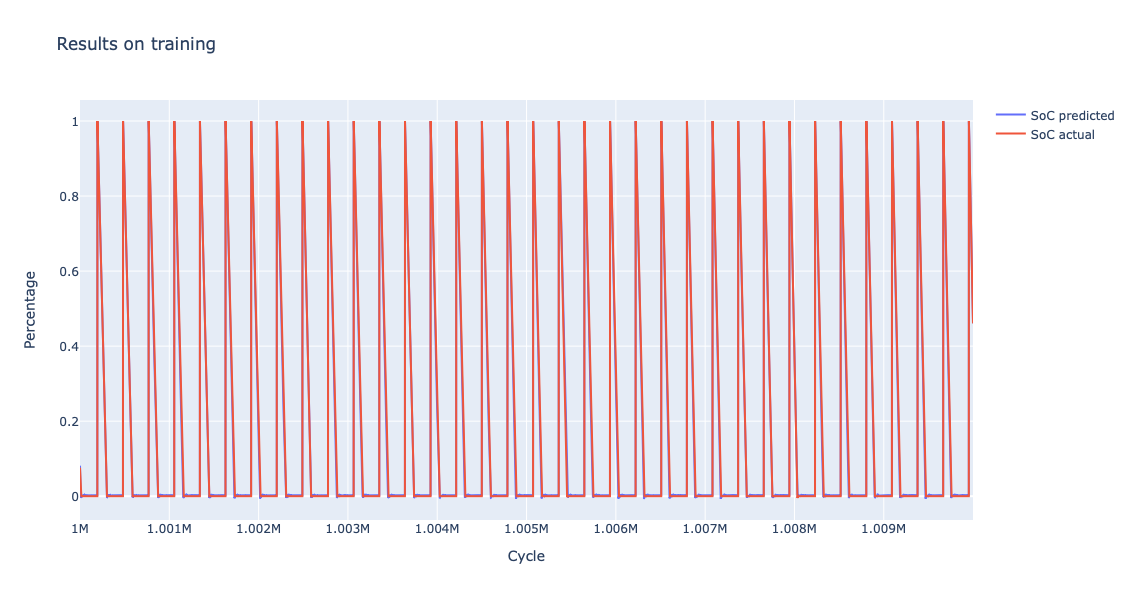

In [15]:
cycle_num = 100
steps_num = 10000
step_index = np.arange(cycle_num*steps_num, (cycle_num+1)*steps_num)

fig = go.Figure()
fig.add_trace(go.Scatter(x=step_index, y=train_predictions.flatten()[cycle_num*steps_num:(cycle_num+1)*steps_num],
                    mode='lines', name='SoC predicted'))
fig.add_trace(go.Scatter(x=step_index, y=train_y.flatten()[cycle_num*steps_num:(cycle_num+1)*steps_num],
                    mode='lines', name='SoC actual'))
fig.update_layout(title='Results on training',
                  xaxis_title='Cycle',
                  yaxis_title='Percentage',
                  width=1400,
                  height=600)
fig.show()

# Testing

In [19]:
font = FontProperties()
font.set_family('serif')
font.set_name('Linux Libertine')

In [23]:
def plot_test_results(test_index, next_test_index, test_name):
    
    print(test_name + ':')
    
    test_x_under_test_name = test_x[test_index:next_test_index]
    test_y_under_test_name = test_y[test_index:next_test_index]    
    print(model.evaluate(test_x_under_test_name, test_y_under_test_name))
    
    plot_begin_and_end(test_index, test_name, 'Begining')    
    plot_begin_and_end(next_test_index - 2, test_name, 'Ending')

def plot_begin_and_end(index, test_name, cycle_name):
    # Remove zero-padded value in cycle end...
    max_index = np.argmax(test_y[index] <= 0)
    if(max_index == 0):
        max_index = test_y[index].shape[0] 
    test_predictions = model.predict(test_x[index:index+1])
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=test_predictions[0][:max_index,0], mode='lines', name='SoC predicted'))
    fig.add_trace(go.Scatter(y=test_y[index][:max_index], mode='lines', name='SoC actual'))
    fig.update_layout(title='Results on testing of %s (%s cycle) ' % (test_name, cycle_name),
                      xaxis_title='Cycle',
                      yaxis_title='SoC percentage')
    fig.show()
    
    gen_chart(test_name, cycle_name, test_y[index][:max_index], test_predictions[0][:max_index,0])
    
    
    
def gen_chart(test_name, cycle_name, test_y, predicted_y):    
    f = plt.figure(figsize=(5,2))
    plt.plot(test_y, label='Actual', color='black')
    plt.plot(predicted_y, label='Estimated', linestyle='--', color='red')
    plt.xlabel('Step', fontproperties=font)
    plt.ylabel('SOC', fontproperties=font)
    plt.legend()
    plt.show()
    f.savefig('./lstm+soc_percentage_all_test_%s_%s.pdf' % (test_name, cycle_name), bbox_inches='tight')

In [24]:
# Get corresponding cycle index of each test name
indecies = list()
train_discharge_cyc,train_discharge_cap,test_discharge_cyc,test_discharge_cap = dataset.get_discharge_data()
for name in test_data_test_names:
    indecies.append(np.argmax(test_discharge_cap[:,0] == name))

003-DM-3.0-4019-S:
12/12 [==============================] - 1s 118ms/step - loss: 2.6878e-05 - mean_squared_error: 5.3755e-05 - mean_absolute_error: 0.0052 - mean_absolute_percentage_error: 937306.6875 - rmse: 0.0073
[2.6877678465098143e-05, 5.3755356930196285e-05, 0.0052359942346811295, 937306.6875, 0.007331804372370243]


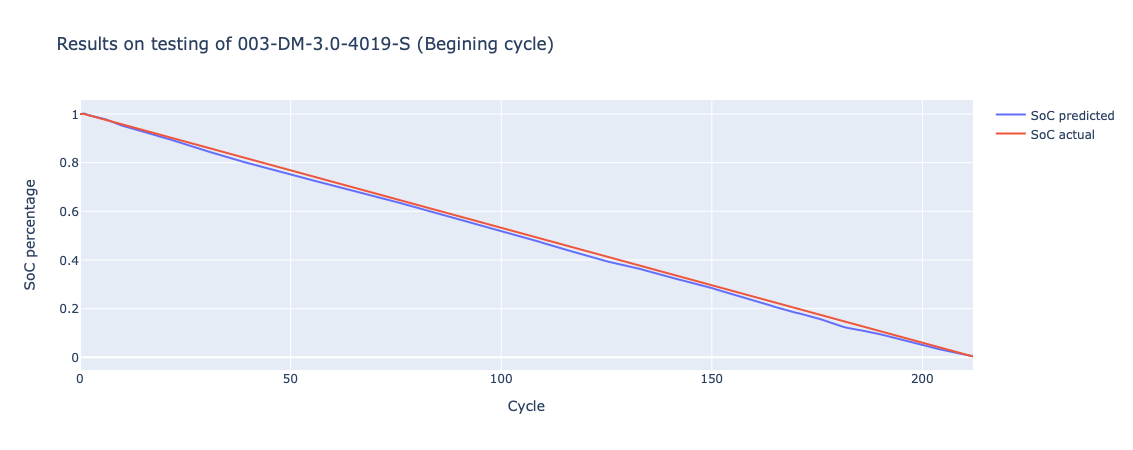

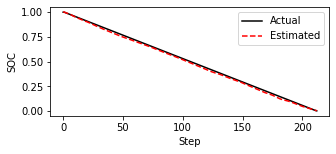

2021/01/10 16:26:03 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:03 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:03 [DEBUG]: Writing TrueType font.


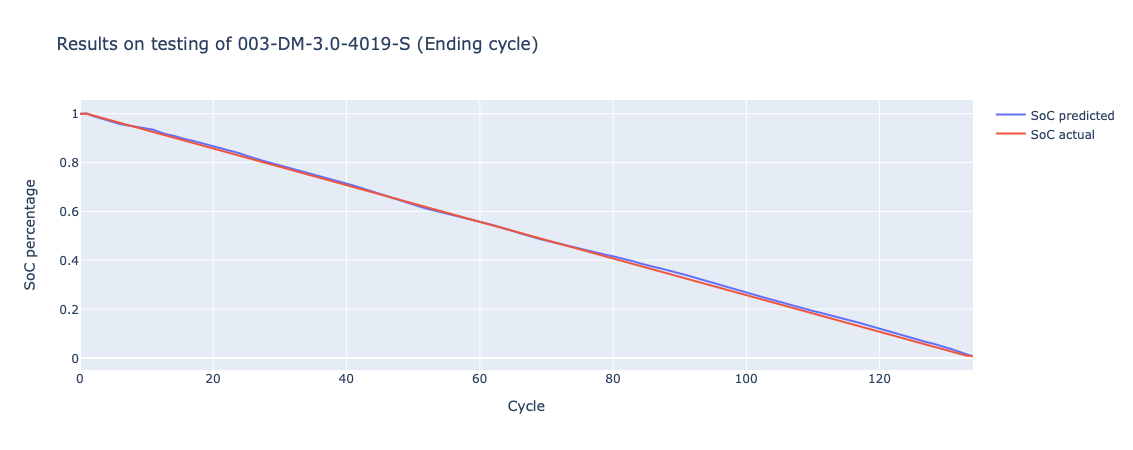

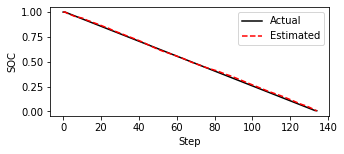

2021/01/10 16:26:04 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:04 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:04 [DEBUG]: Writing TrueType font.


008-EE-2.85-0820-S:
22/22 [==============================] - 3s 123ms/step - loss: 7.7771e-06 - mean_squared_error: 1.5554e-05 - mean_absolute_error: 0.0031 - mean_absolute_percentage_error: 874327.3125 - rmse: 0.0039
[7.777092832839116e-06, 1.5554185665678233e-05, 0.0030699570197612047, 874327.3125, 0.003943879157304764]


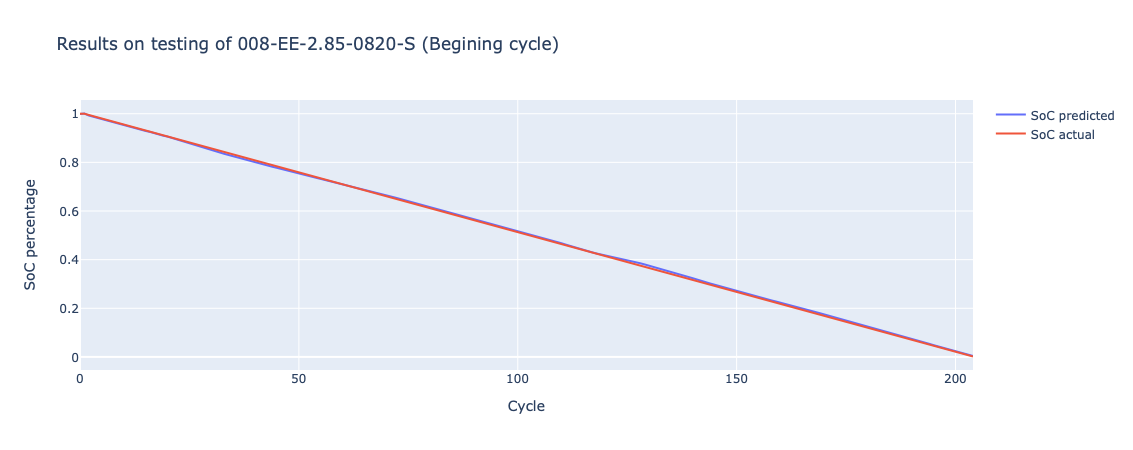

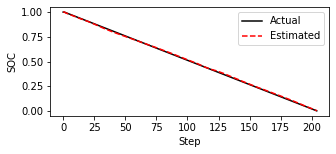

2021/01/10 16:26:07 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:07 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:07 [DEBUG]: Writing TrueType font.


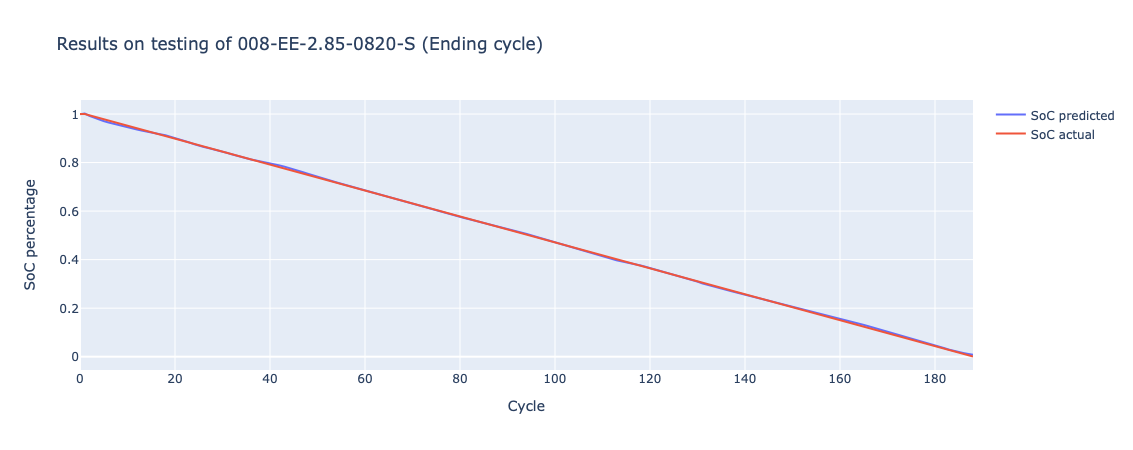

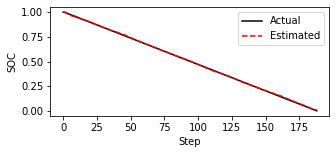

2021/01/10 16:26:08 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:08 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:08 [DEBUG]: Writing TrueType font.


011-DM-3.0-4019-H:
15/15 [==============================] - 2s 112ms/step - loss: 1.8753e-05 - mean_squared_error: 3.7507e-05 - mean_absolute_error: 0.0046 - mean_absolute_percentage_error: 1610058.0000 - rmse: 0.0061
[1.8753455151454546e-05, 3.750691030290909e-05, 0.0045558796264231205, 1610058.0, 0.006124288775026798]


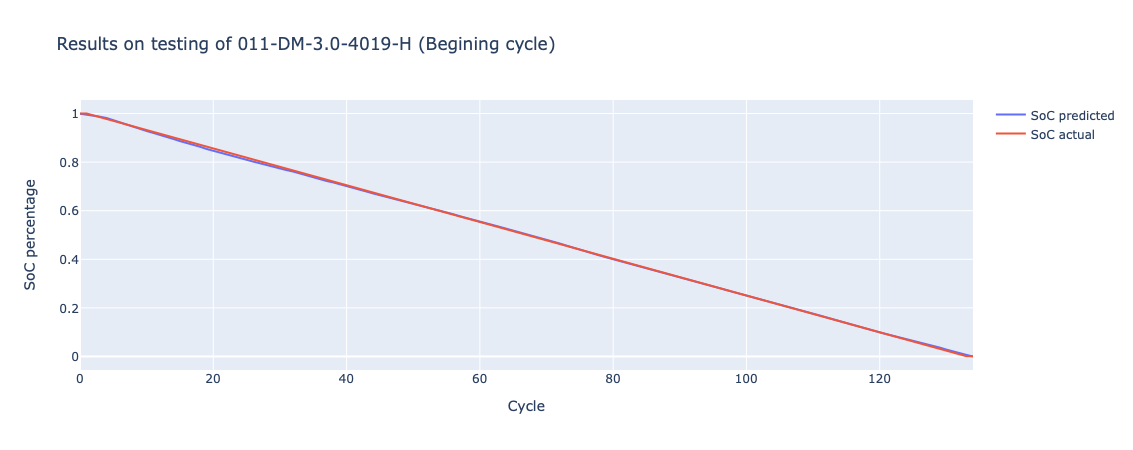

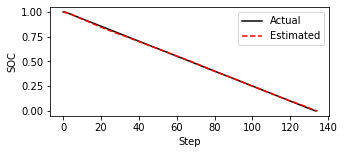

2021/01/10 16:26:10 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:10 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:10 [DEBUG]: Writing TrueType font.


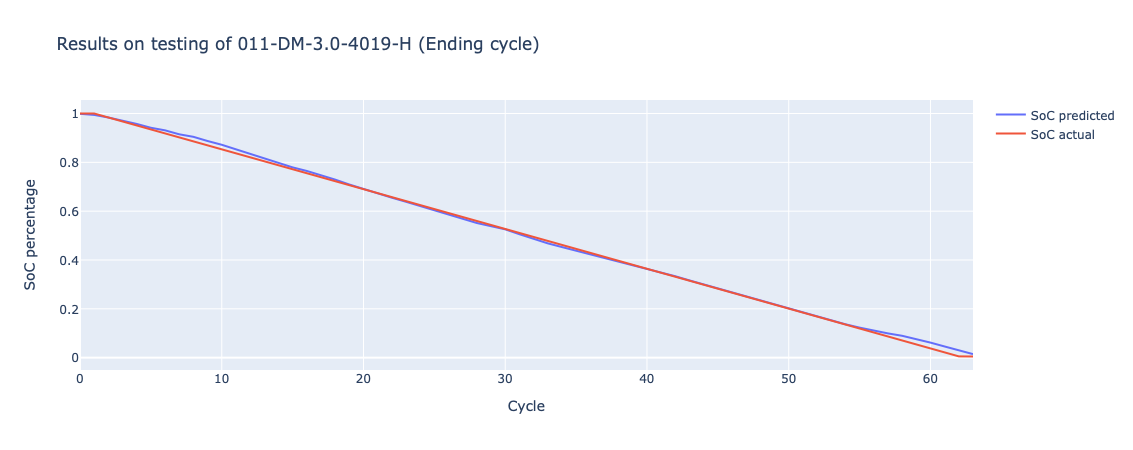

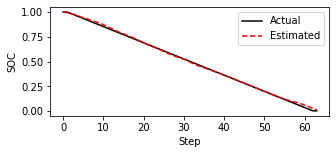

2021/01/10 16:26:11 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:11 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:11 [DEBUG]: Writing TrueType font.


017-DM-3.0-4019-P:
11/11 [==============================] - 1s 114ms/step - loss: 2.1609e-05 - mean_squared_error: 4.3217e-05 - mean_absolute_error: 0.0047 - mean_absolute_percentage_error: 1069449.6250 - rmse: 0.0066
[2.1608715542242862e-05, 4.3217431084485725e-05, 0.004708776716142893, 1069449.625, 0.006573996972292662]


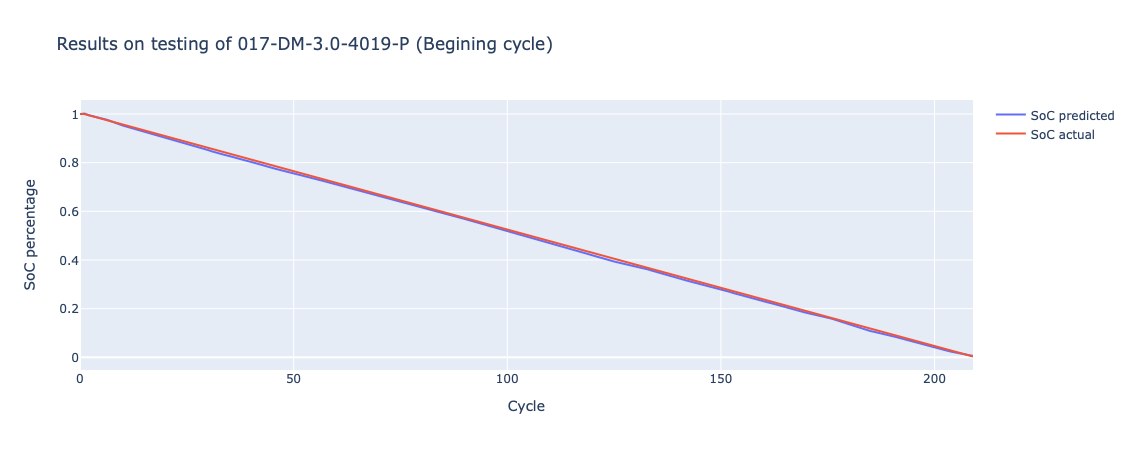

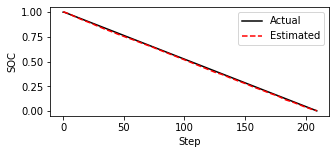

2021/01/10 16:26:13 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:13 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:13 [DEBUG]: Writing TrueType font.


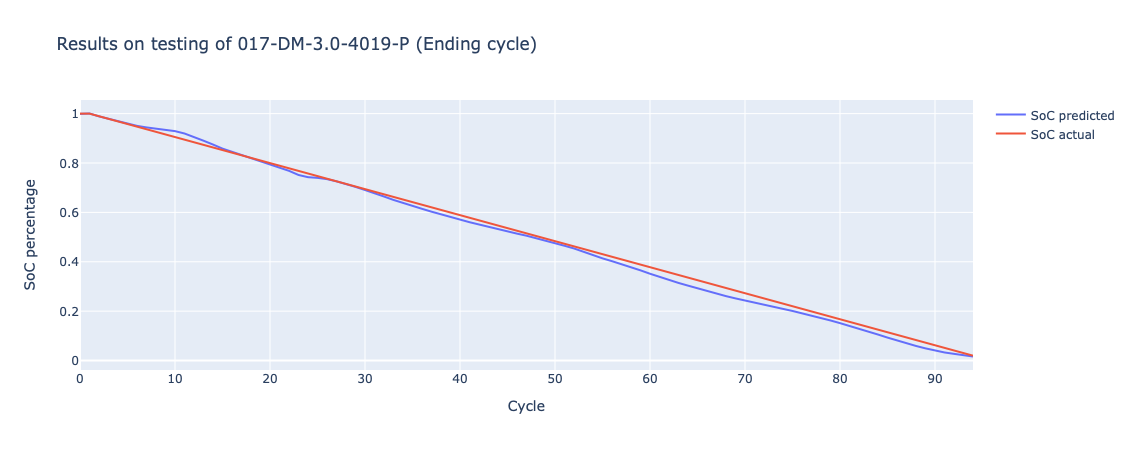

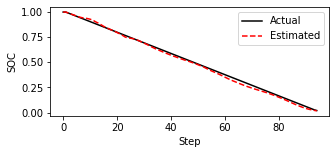

2021/01/10 16:26:13 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:13 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:13 [DEBUG]: Writing TrueType font.


039-DP-2.00-2420-S:
8/8 [==============================] - 1s 113ms/step - loss: 3.2121e-05 - mean_squared_error: 6.4242e-05 - mean_absolute_error: 0.0059 - mean_absolute_percentage_error: 1257028.2500 - rmse: 0.0080
[3.212086085113697e-05, 6.424172170227394e-05, 0.005908292718231678, 1257028.25, 0.008015093393623829]


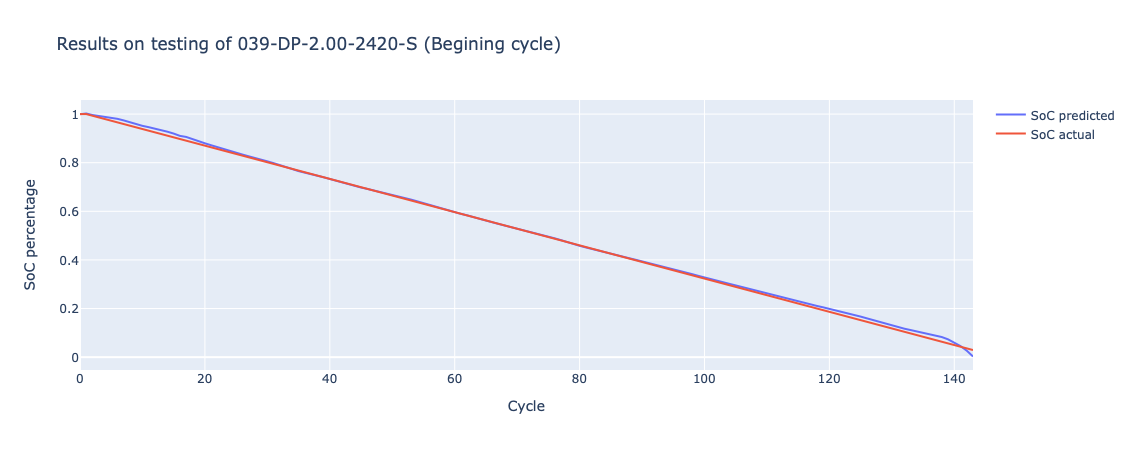

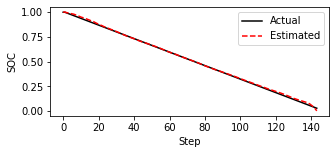

2021/01/10 16:26:15 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:15 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:15 [DEBUG]: Writing TrueType font.


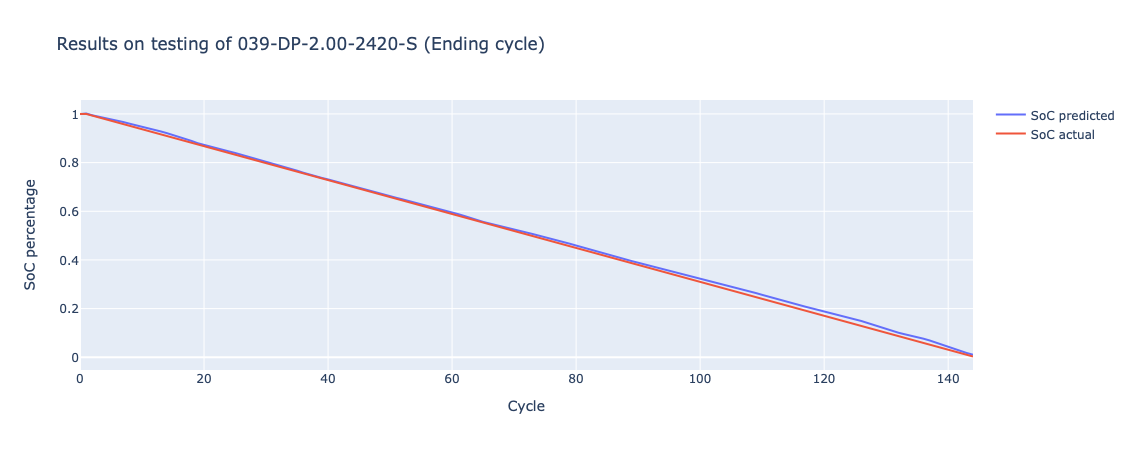

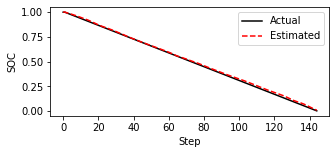

2021/01/10 16:26:15 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:15 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:15 [DEBUG]: Writing TrueType font.


044-EE-2.85-0820-H:
6/6 [==============================] - 1s 104ms/step - loss: 5.2387e-04 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0213 - mean_absolute_percentage_error: 2450571.7500 - rmse: 0.0324
[0.0005238686571829021, 0.0010477373143658042, 0.021270131692290306, 2450571.75, 0.032368771731853485]


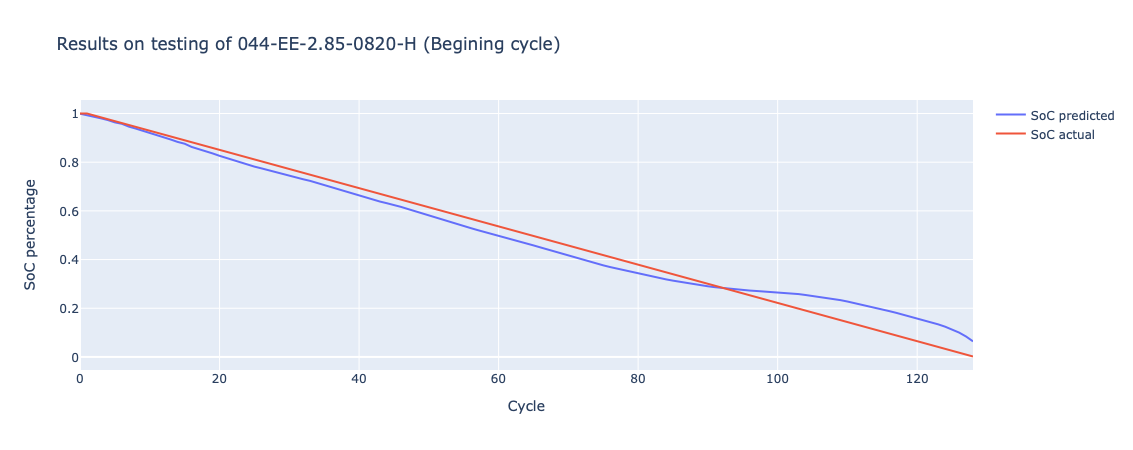

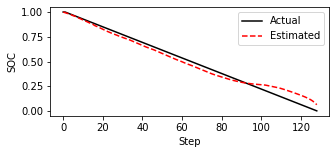

2021/01/10 16:26:16 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:16 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:16 [DEBUG]: Writing TrueType font.


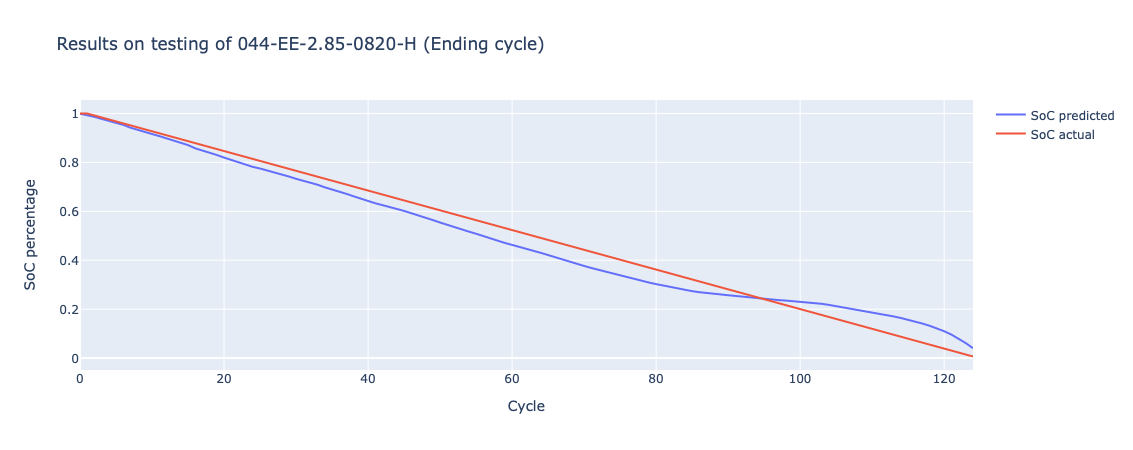

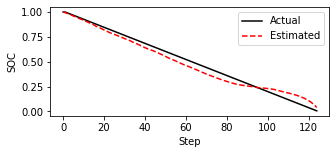

2021/01/10 16:26:17 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:17 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:17 [DEBUG]: Writing TrueType font.


041-DM-4.00-2320-S:
5/5 [==============================] - 0s 100ms/step - loss: 5.8610e-04 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0268 - mean_absolute_percentage_error: 85852.6719 - rmse: 0.0342
[0.0005860960227437317, 0.0011721920454874635, 0.026846209540963173, 85852.671875, 0.03423728793859482]


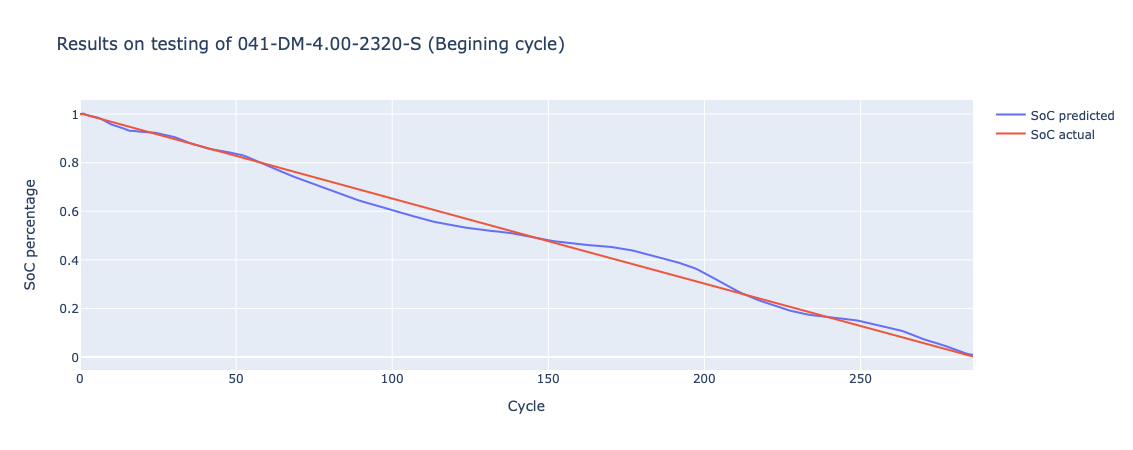

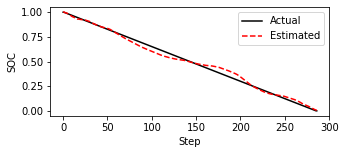

2021/01/10 16:26:18 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:18 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:18 [DEBUG]: Writing TrueType font.


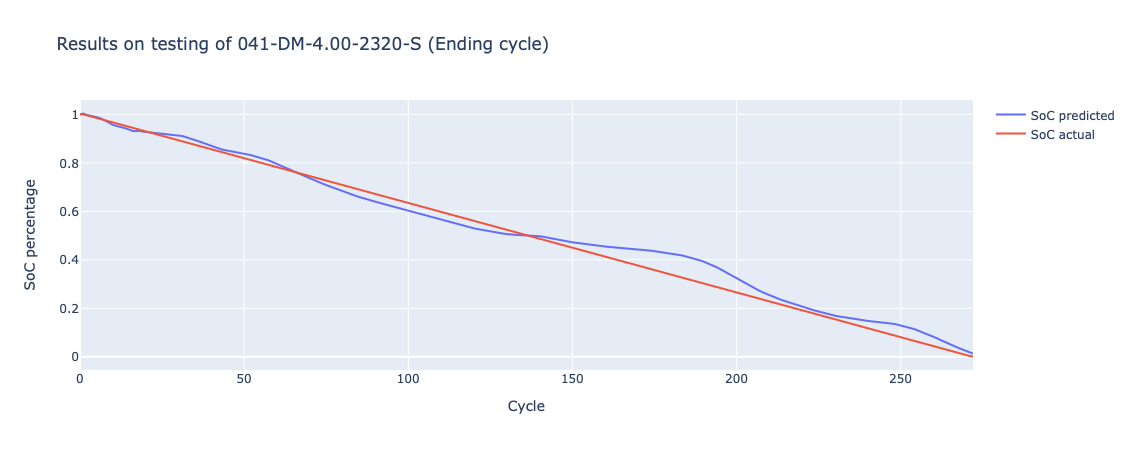

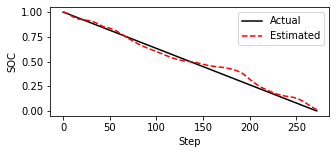

2021/01/10 16:26:18 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/10 16:26:18 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/10 16:26:18 [DEBUG]: Writing TrueType font.


In [25]:
for i in range(len(indecies)):
    if(i == len(indecies)-1):
        plot_test_results(indecies[i], -1, test_data_test_names[i])
    else:
        plot_test_results(indecies[i], indecies[i+1], test_data_test_names[i])        